In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
mpl.use("agg")
import matplotlib.pyplot as plt
import bioframe as bf
%matplotlib inline
import seaborn as sns
import bbi

In [22]:
bbi.__version__

'0.3.2'

In [3]:
mpl.rcParams.update({'pdf.fonttype': 42,
                     'ps.fonttype': 42,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14, 
                     'axes.labelsize':14,
                     'font.size': 14})

In [4]:
def calculate_signal_per_peak(
    region,
    chip_path,
    center):
    # Calculates mean ChIP-seq signal within one peak  
    chroms = region.chrom
    starts = region[center] - 300
    ends = region[center] + 300
    stack = bbi.stackup(chip_path, chroms, starts, ends, bins=100) 
    return np.nanmean(stack, axis=1)

In [5]:
resDir = "/groups/gerlich/experiments/Experiments_005700/005759/data/selections/Sororin_vs_CTCF/"

## Upload peaks

In [14]:
# Upload SMC3 ChIP-seq peaks 
smc3 = pd.read_csv("/groups/gerlich/experiments/Experiments_005000/005019/data/Smc3_clean.bed", sep = "\t")
smc3 = smc3.iloc [:,:3]
smc3.columns = ['chrom', 'start', 'end']
# Compute the length of the SMC3 peak 
smc3['length'] = smc3.end - smc3.start
# Discard peaks that mapped to ChrY 
smc3 = smc3 [smc3.chrom != 'chrY']
#smc3 = smc3.drop_duplicates()
smc3['mid'] = (smc3.end + smc3.start)//2
smc3 

,chrom,start,end,length,mid
0,chr1,10936,11845,909,11390
1,chr1,15496,15732,236,15614
2,chr1,90977,91957,980,91467
3,chr1,104568,105527,959,105047
4,chr1,138548,139623,1075,139085
...,...,...,...,...,...
34786,chrX,154376937,154377863,926,154377400
34787,chrX,154891956,154892607,651,154892281
34788,chrX,155049325,155050443,1118,155049884
34789,chrX,155196405,155197156,751,155196780


## Upload ChIP-seq tracks 

In [15]:
chipMap = {"SMC3": "/groups/gerlich/experiments/Experiments_004900/004983/data/chip_seq_input_norm/SMC3_merged_input_norm_log2.bw",
            "Sororin": "/groups/gerlich/experiments/Experiments_004900/004983/data/chip_seq_input_norm/Sororin_merged_input_norm_log2.bw"}

## Calcluate ChIP-seq signal  

In [16]:
for condition in ['SMC3', 'Sororin']: 
    peak_chip_value = calculate_signal_per_peak (smc3, chipMap[condition], 'mid')
    smc3 [condition] = peak_chip_value

In [17]:
smc3.replace([np.inf, -np.inf], np.nan, inplace=True)
smc3.dropna(axis = 0, inplace = True)

## Plot the scatter plots for signal distribution 

In [18]:
thre = 0.1

In [19]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

/users/sofia.kolesnikova/.local/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/users/sofia.kolesnikova/.local/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


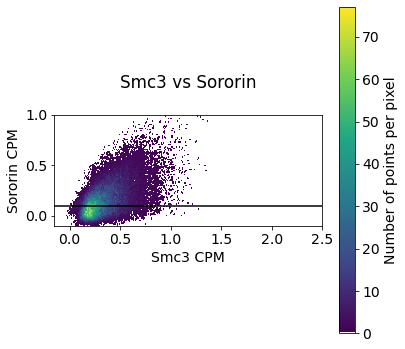

In [20]:
f = plt.figure(figsize=(6,6))
using_mpl_scatter_density(f, smc3['SMC3'],smc3['Sororin'])
plt.xlabel('Smc3 CPM')
plt.ylabel('Sororin CPM')
plt.title('Smc3 vs Sororin\n')
plt.gca().set(
    xlim=(-0.15,2.5),
    ylim=(-0.1,1),
    aspect=1.0
)
plt.axhline(thre, color = 'black')
#plt.axvline(0.3, color = 'black')
plt.show();

## Define two classes of peaks 

In [21]:
smc3_wo_sororin = smc3[(smc3.Sororin < thre)]
smc3_w_sororin = smc3[(smc3.Sororin > thre)]

In [22]:
print (f"Number of SMC3 w Sororin: {len(smc3_w_sororin)}")
print (f"Number of SMC3 wo Sororin: {len(smc3_wo_sororin)}")

Number of SMC3 w Sororin: 20943
Number of SMC3 wo Sororin: 13848


In [23]:
resDir = "/groups/gerlich/experiments/Experiments_005700/005784/data/signal_peak_classification/"
smc3_wo_sororin.to_csv(os.path.join(resDir, "smc3_wo_sororin.bed"), sep = '\t', header = True, index = None)
smc3_w_sororin.to_csv(os.path.join(resDir, "smc3_w_sororin.bed"), sep = '\t', header = True, index = None)